In [4]:
# BigQuery connection
%load_ext google.cloud.bigquery

In [5]:
# imports
from google.cloud import bigquery
import pandas as pd
import numpy as np
from bq_helper import BigQueryHelper
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [6]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Downloads/ambient-fuze-343609-fc7da1815720.json"

In [7]:
client = bigquery.Client()

In [6]:
# Test: Top 1000 bigquery balances
%%bigquery Top_1000_balances
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC

Downloading: 100%|███████████████████████| 1000/1000 [00:01<00:00, 666.91rows/s]


In [7]:
Top_1000_balances

,address,type,balance
0,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo,scripthash,25259722953995.000000000
1,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...,witness_v0_scripthash,16800998565831.000000000
2,1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ,pubkeyhash,12642856918840.000000000
3,3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb,scripthash,11660113654657.000000000
4,bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt,witness_v0_keyhash,9464329910722.000000000
...,...,...,...
995,15HDbh92juxL9NRW4sm8wo3hmDoc32vWNM,pubkeyhash,186109810245.000000000
996,1CeD3b9j2KeSN3BgfcQCSpENCA99dg3qQp,pubkeyhash,186042495808.000000000
997,33wbHsWMaf2KSDAWr792oozC4miHLt1VZq,scripthash,185677858631.000000000
998,1N3WD1vDYUdUsn9BKpjoEHryZtgNW66xqD,pubkeyhash,185005233187.000000000


In [8]:
# Bigquery Helper
bitcoin = BigQueryHelper("bigquery-public-data","bitcoin_blockchain")

bitcoin.list_tables()

['blocks', 'transactions']

## Exploratory Data Analysis

In [37]:
%%bigquery gini_index
WITH double_entry_book AS (
    -- debits
    SELECT
     array_to_string(inputs.addresses, ",") as address
    , inputs.type
    , -inputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
 
    UNION ALL
 
    -- credits
    SELECT
     array_to_string(outputs.addresses, ",") as address
    , outputs.type
    , outputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2009-01-12', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

Downloading: 100%|██████████████████████| 4810/4810 [00:01<00:00, 2976.58rows/s]


In [39]:
#dataset for Gini index to compare with other econometric measures
gini_index['gini'] = gini_index['gini'].astype('float64')
gini_index['date'] = pd.to_datetime(gini_index['date'])

gini_index.info()

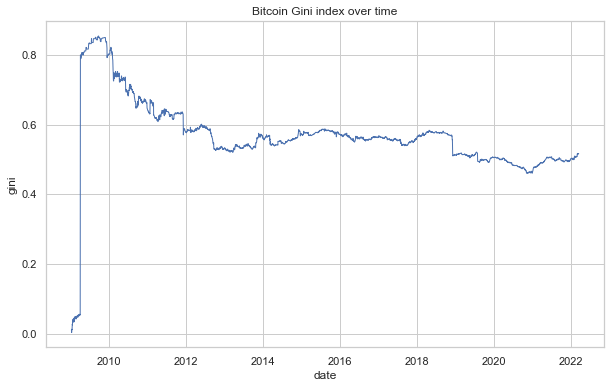

In [40]:
plt.figure(figsize = [10,6])
sns.lineplot(data=gini_index, x = 'date', y = 'gini', palette="tab10", linewidth=1)
plt.title("Bitcoin Gini index over time")
plt.show()

In [41]:
# export gini index dataset to avoid running query again 
gini_index.to_csv("Bitcoin_Gini-index.csv")

In [49]:
# transaction fees bitcoin data
query = """
SELECT 
    ROUND((input_value - output_value)/ size, 0) AS fees_per_byte,
    COUNT(*) AS txn_cnt
FROM
  `bigquery-public-data.crypto_bitcoin.transactions`
WHERE TRUE
  AND block_timestamp >= '2018-01-01' 
  AND is_coinbase IS FALSE
GROUP BY 1
"""
query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
zero_fee_btc = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10 headlines
zero_fee_btc.columns

Index(['fees_per_byte', 'txn_cnt'], dtype='object')

In [53]:
zero_fee_btc

,fees_per_byte,txn_cnt
0,2783,6
1,5285,1
2,6913,2
3,5918,1
4,3786,3
...,...,...
8154,12396,1
8155,4896,4
8156,8132,2
8157,8069,1


In [54]:
query = """
#standardSQL
SELECT
  o.day,
  COUNT(o.transaction_id) AS NoOfTrans
FROM (
  SELECT
    TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day,
    transaction_id
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions` ) AS o
GROUP BY
  day
ORDER BY
NoOfTrans desc
"""
query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
trans_day = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10 headlines
trans_day.head()

,day,NoOfTrans
0,2017-12-14 00:00:00+00:00,490644
1,2017-12-06 00:00:00+00:00,443587
2,2018-01-04 00:00:00+00:00,425008
3,2017-12-13 00:00:00+00:00,424579
4,2017-12-01 00:00:00+00:00,412908


In [11]:
def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=30)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result
    

## Transactions

In [8]:
trans_day = run_query("SELECT * FROM `bigquery-public-data.crypto_bitcoin.transactions` as transactions WHERE transactions.hash = 'a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d'")

In [12]:
# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

In [18]:
# Preview the first five lines of the "transactions" table
transactions = client.list_rows(table, max_results=5).to_dataframe()

In [19]:
transactions.head()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


In [20]:
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

In [27]:
trans_by_date = run_query(query_with_CTE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   transactions  4815 non-null   int64 
 1   trans_date    4815 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.4+ KB


In [28]:
trans_by_date['trans_date'] = pd.to_datetime(trans_by_date['trans_date'])

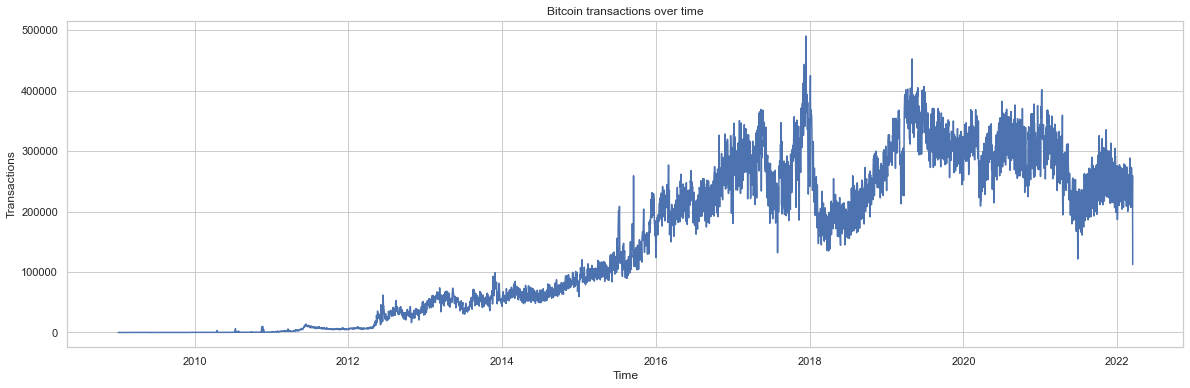

In [32]:
plt.figure(figsize=[20,6])

x = trans_by_date['trans_date']
y = trans_by_date['transactions']

plt.plot(x,y)

plt.xlabel("Time")
plt.ylabel("Transactions")
plt.title("Bitcoin transactions over time")

plt.show()

## Blocks

In [17]:
# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("blocks")

# API request - fetch the table
table = client.get_table(table_ref)

In [18]:
# Preview the first five lines of the "blocks" table
blocks = client.list_rows(table, max_results=100).to_dataframe()

In [19]:
blocks

,hash,size,stripped_size,weight,number,version,merkle_root,timestamp,timestamp_month,nonce,bits,coinbase_param,transaction_count
0,0000000000000001a6c33cbacd7eddf513adfcc24ef292...,109539,109539,438156,277713,2,e59964d21c6089dfab04a0ac5d92f8e672d5c64d339d62...,2013-12-30 10:08:34+00:00,2013-12-01,45927e1e,1903a30c,03d13c040452c1462217000000c9840100,256
1,00000000000000007d3f7b4089fee3b9cec3dd9431c7cd...,122262,122262,489048,277703,2,8adf2657f12817b6bac9e7d7db507e160849055f176bc3...,2013-12-30 08:59:35+00:00,2013-12-01,8b0ee036,1903a30c,03c73c04062f503253482f04f835c15208202f63920000...,256
2,000000000000000380303abc3612c9bb00265cb489d454...,247736,247736,990944,276608,2,c3b7689605130d1060145346390d9ae7bf34ce9d47b540...,2013-12-23 22:05:51+00:00,2013-12-01,8866bae6,1903a30c,03803804040009419559124d696e656420627920425443...,256
3,0000000000000000e392598c1363cd3640d22df6b7c765...,159843,159843,639372,276824,2,627d939a32fa1083defdf43d4024c259fcb76c6b665672...,2013-12-25 04:36:57+00:00,2013-12-01,28df2f5f,1903a30c,035839040d00456c69676975730052ba60e9fabe6d6d71...,256
4,00000000000000031496fe6863271fb6fe69bd4ddf5bfc...,95961,95961,383844,277687,2,c04eba1ee9c938ae5931beb391f442c1bcb7869dec85fd...,2013-12-30 07:44:02+00:00,2013-12-01,8ca9cd5c,1903a30c,03b73c040552c124400c6100000000000028,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,000000000000000029e7ab1e48711605ee6c0fdddcd7c8...,149196,149196,596784,276650,2,6941b32cdf7234c171117a7c897c9e3676977ba6242999...,2013-12-24 03:27:06+00:00,2013-12-01,68be8427,1903a30c,03aa3804040007ff9444124d696e656420627920425443...,265
96,000000000000000235f8204373239a92c1a1bf48306055...,222568,222568,890272,277649,2,6312a45b573fe627304d328e7f0c14851b9414ba6ac8b6...,2013-12-30 02:02:19+00:00,2013-12-01,c7d1a52e,1903a30c,03913c0404000043e144124d696e656420627920425443...,521
97,000000000000000253ba02569c9b6325a4a4366da25a89...,349154,349154,1396616,277800,2,ca7325be57d6895593cbd6448b0f87fe848c6f4cb739e6...,2013-12-30 21:01:00+00:00,2013-12-01,f261459e,1903a30c,03283d04094269744d696e746572062f503253482f2cfa...,777
98,0000000000000000520a9b6fd70f818bb99eb8679b2a1a...,4595,4595,18380,277386,2,ad7ceea00996d81c5dbd85d21ba916affdfcffaf5e8c42...,2013-12-28 10:12:55+00:00,2013-12-01,d552db6f,1903a30c,038a3b040c4ee273a0c85066cb44eb7210,10


In [15]:
query = """
SELECT TIMESTAMP(timestamp) FROM `bigquery-public-data.bitcoin_blockchain.blocks`
"""

In [13]:
# Test: Top 1000 bigquery balances
query = '''
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 1000
'''

In [14]:
run_query(query)

TimeoutError: Operation did not complete within the designated timeout.